In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from data_utils import load_and_preprocess_data, train_val_test_split
from rnn_model import RNN
from train import train_model, evaluate_metrics
import warnings
from visualization_utils import plot_predictions, calculate_prediction_metrics, make_predictions,plot_test_predictions_only
import pandas as pd
import numpy as np
from model import ATTLSTM,TimeAttentionRNN,FeatureAttentionRNN
from models import GRU
warnings.filterwarnings("ignore")

## RNN

In [ ]:
file_path = "GOOG.csv"
sequence_length = 15
prediction_length = 1
batch_size = 64
hidden_size = 256
num_layers = 1
num_epochs = 30
learning_rate = 0.0001
dropout_rate = 0.2
weight_decay = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X, y, scalers = load_and_preprocess_data(file_path, sequence_length, prediction_length)

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = X.shape[2]  
rnn = RNN(input_size, hidden_size, 1, num_layers=num_layers, dropout=dropout_rate).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_model(rnn, train_loader, val_loader, criterion, optimizer, num_epochs,"rnn", device)


In [128]:
rnn = torch.load("rnn_best_model.pth", map_location=device) 
predictions, actuals, metrics = evaluate_metrics(rnn, test_loader, criterion, scalers, device)


Evaluation Metrics:
MSE (normalized): 0.0011
MAE (normalized): 0.0281
MSE (original scale): 26.9201
MAE (original scale): 4.3526

Value Ranges:
Predictions - Min: 87.21, Max: 143.03
Actuals - Min: 83.49, Max: 150.71


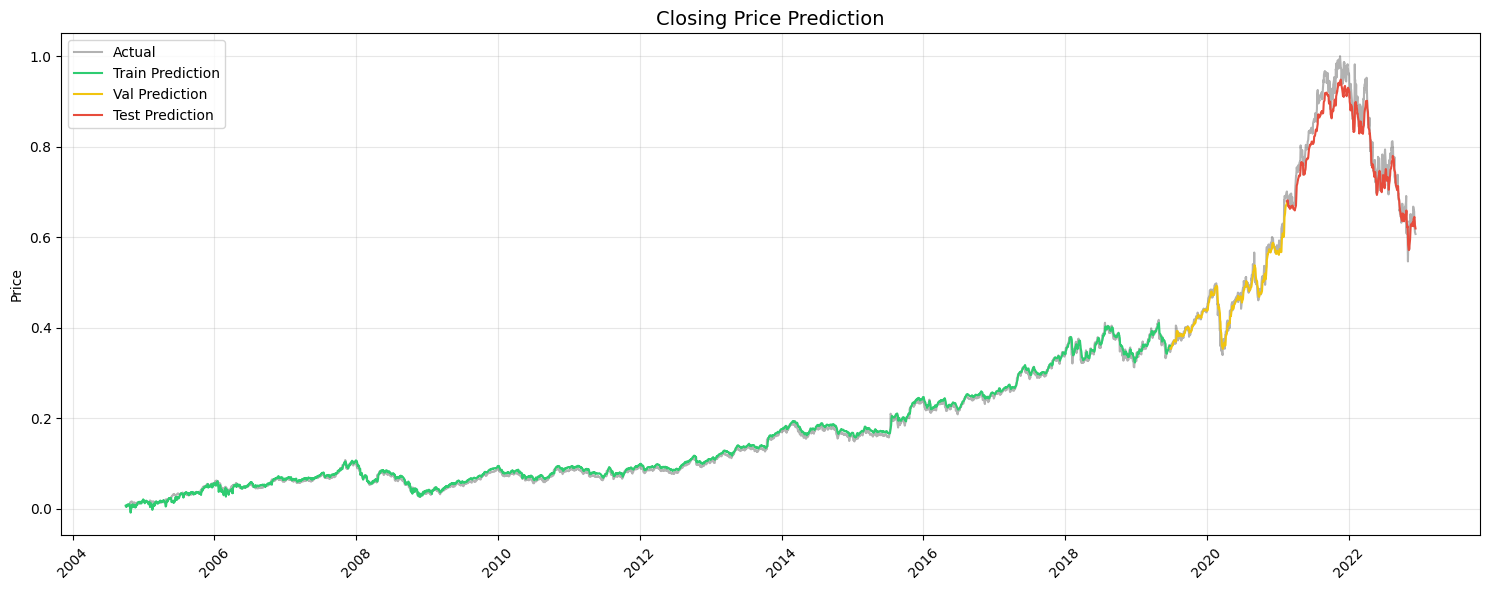

In [129]:
df = pd.read_csv(file_path)
dates = pd.to_datetime(df['Date'], format='%d-%m-%Y')

train_pred, train_actual = make_predictions(rnn, train_loader, device)
val_pred, val_actual = make_predictions(rnn, val_loader, device)
test_pred, test_actual = make_predictions(rnn, test_loader, device)

all_predictions = np.concatenate([train_pred, val_pred, test_pred], axis=0)
all_actuals = np.concatenate([train_actual, val_actual, test_actual], axis=0)

valid_dates = dates[sequence_length:sequence_length+len(all_predictions)]

set_splits = {
    'train': (0, len(train_pred)),
    'val': (len(train_pred), len(train_pred) + len(val_pred)),
    'test': (len(train_pred) + len(val_pred), len(train_pred) + len(val_pred) + len(test_pred))
}

plot_predictions(
    all_predictions, 
    all_actuals, 
    valid_dates, 
    scalers, 
    set_splits, 
    title='Google Stock Price Prediction'
)



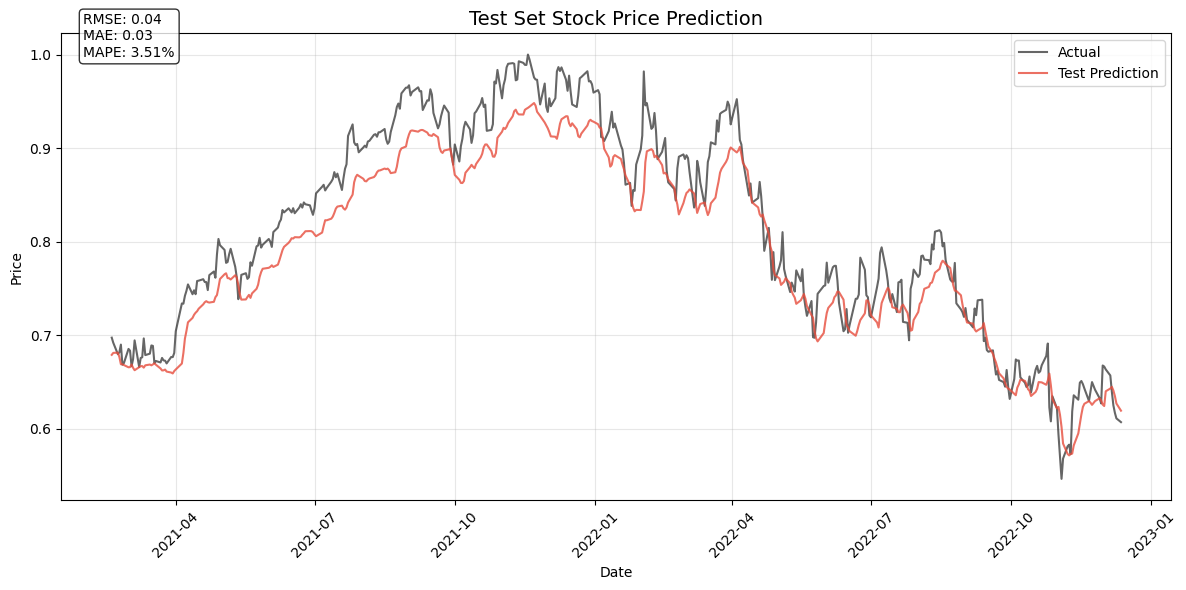


Test Set Metrics:
RMSE: 0.04
MAE: 0.03
MAPE: 3.51%


In [131]:
plot_test_predictions_only(rnn, test_loader, dates, sequence_length, device)

# GRU

In [ ]:
sequence_length = 30
prediction_length = 1
batch_size = 64
hidden_size = 256
num_layers = 1
num_epochs = 30
learning_rate = 0.0001
dropout_rate = 0.1
weight_decay = 1e-4

input_size = X.shape[2]  
output_size = 1
gru = GRU(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout_rate).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_model(gru, train_loader, val_loader, criterion, optimizer, num_epochs, "GRU",device)


Epoch [1/30] - Train Loss: 0.0014, Val Loss: 0.0029
Epoch [2/30] - Train Loss: 0.0095, Val Loss: 0.0088
Epoch [3/30] - Train Loss: 0.0034, Val Loss: 0.0017
Epoch [4/30] - Train Loss: 0.0005, Val Loss: 0.0003
Epoch [5/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [6/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [7/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [8/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [9/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [10/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [11/30] - Train Loss: 0.0000, Val Loss: 0.0003
Epoch [12/30] - Train Loss: 0.0000, Val Loss: 0.0003
Epoch [13/30] - Train Loss: 0.0000, Val Loss: 0.0003
Epoch [14/30] - Train Loss: 0.0000, Val Loss: 0.0003
Epoch [15/30] - Train Loss: 0.0000, Val Loss: 0.0003
Epoch [16/30] - Train Loss: 0.0000, Val Loss: 0.0003
Epoch [17/30] - Train Loss: 0.0000, Val Loss: 0.0003
Epoch [18/30] - Train Loss: 0.0000, Val Loss: 0.0003
Epoch [19/30] - Train Loss: 0.0000, Val Loss: 0.0003
Ep

In [87]:
gru = torch.load("GRU_best_model.pth", map_location=device) 
predictions, actuals, metrics = evaluate_metrics(gru, test_loader, criterion, scalers, device)


Evaluation Metrics:
MSE (normalized): 0.0006
MAE (normalized): 0.0205
MSE (original scale): 13.9601
MAE (original scale): 3.0463

Value Ranges:
Predictions - Min: 88.97, Max: 147.68
Actuals - Min: 83.49, Max: 150.71


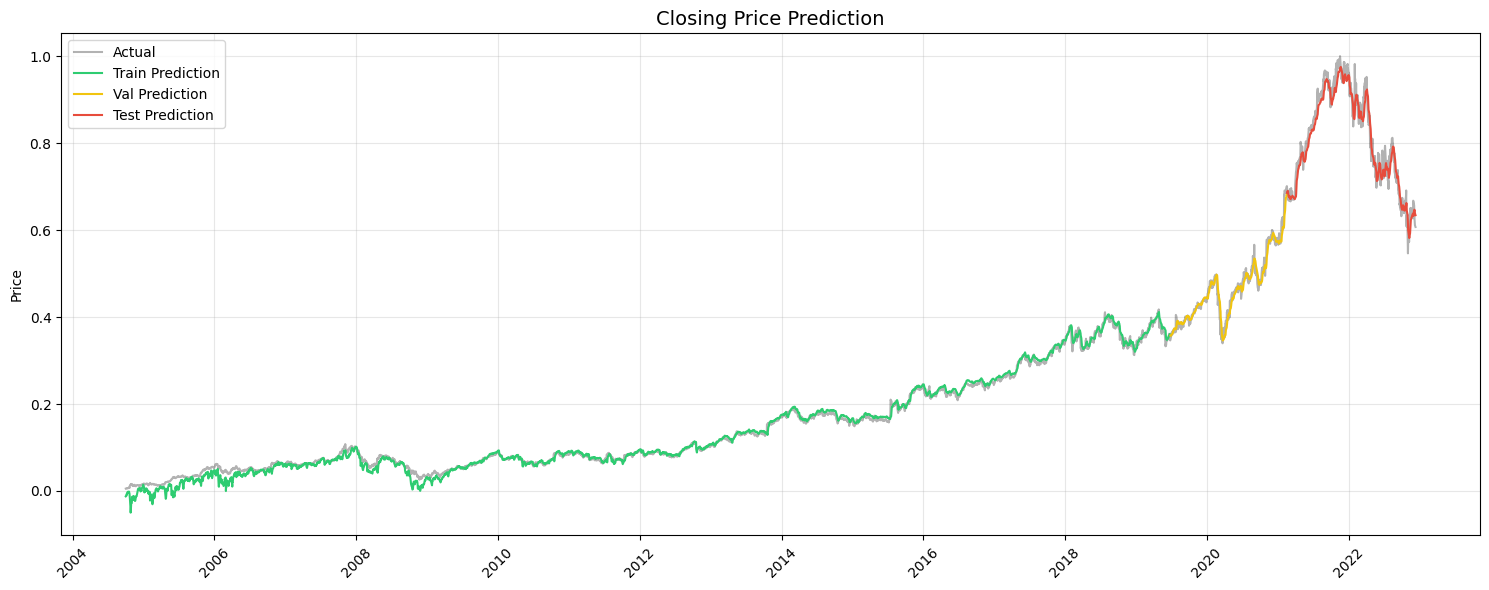


Train Set Metrics:

Val Set Metrics:

Test Set Metrics:


In [ ]:
train_pred, train_actual = make_predictions(gru, train_loader, device)
val_pred, val_actual = make_predictions(gru, val_loader, device)
test_pred, test_actual = make_predictions(gru, test_loader, device)

all_predictions = np.concatenate([train_pred, val_pred, test_pred], axis=0)
all_actuals = np.concatenate([train_actual, val_actual, test_actual], axis=0)

valid_dates = dates[sequence_length:sequence_length+len(all_predictions)]

set_splits = {
    'train': (0, len(train_pred)),
    'val': (len(train_pred), len(train_pred) + len(val_pred)),
    'test': (len(train_pred) + len(val_pred), len(train_pred) + len(val_pred) + len(test_pred))
}

plot_predictions(
    all_predictions, 
    all_actuals, 
    valid_dates, 
    scalers, 
    set_splits, 
    title='Google Stock Price Prediction'
)
    

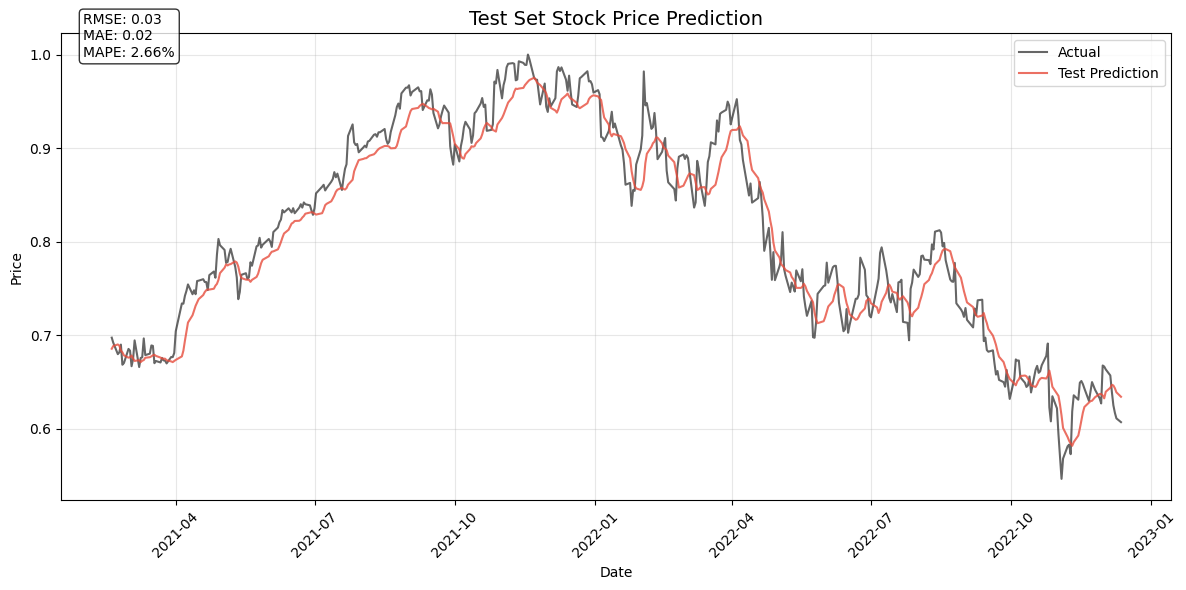


Test Set Metrics:
RMSE: 0.03
MAE: 0.02
MAPE: 2.66%


In [40]:
plot_test_predictions_only(gru, test_loader, dates, sequence_length, device)

## LSTM

In [83]:
from models import LSTM

sequence_length = 30
prediction_length = 1
batch_size = 64
hidden_size = 128
num_layers = 1
num_epochs = 30
learning_rate = 0.0001
dropout_rate = 0.2
weight_decay = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


input_size = X.shape[2]  
output_size = 1
model = LSTM(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout_rate).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, "LSTM",device)


Epoch [1/30] - Train Loss: 0.0075, Val Loss: 0.0539
Epoch [2/30] - Train Loss: 0.0102, Val Loss: 0.0520
Epoch [3/30] - Train Loss: 0.0061, Val Loss: 0.0341
Epoch [4/30] - Train Loss: 0.0043, Val Loss: 0.0173
Epoch [5/30] - Train Loss: 0.0024, Val Loss: 0.0037
Epoch [6/30] - Train Loss: 0.0008, Val Loss: 0.0004
Epoch [7/30] - Train Loss: 0.0001, Val Loss: 0.0005
Epoch [8/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [9/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [10/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [11/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [12/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [13/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [14/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [15/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [16/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [17/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [18/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [19/30] - Train Loss: 0.0001, Val Loss: 0.0004
Ep

In [84]:
lstm = torch.load("LSTM_best_model.pth", map_location=device) 
predictions, actuals, metrics = evaluate_metrics(lstm, test_loader, criterion, scalers, device)


Evaluation Metrics:
MSE (normalized): 0.0008
MAE (normalized): 0.0221
MSE (original scale): 17.9401
MAE (original scale): 3.2308

Value Ranges:
Predictions - Min: 91.96, Max: 148.71
Actuals - Min: 83.49, Max: 150.71


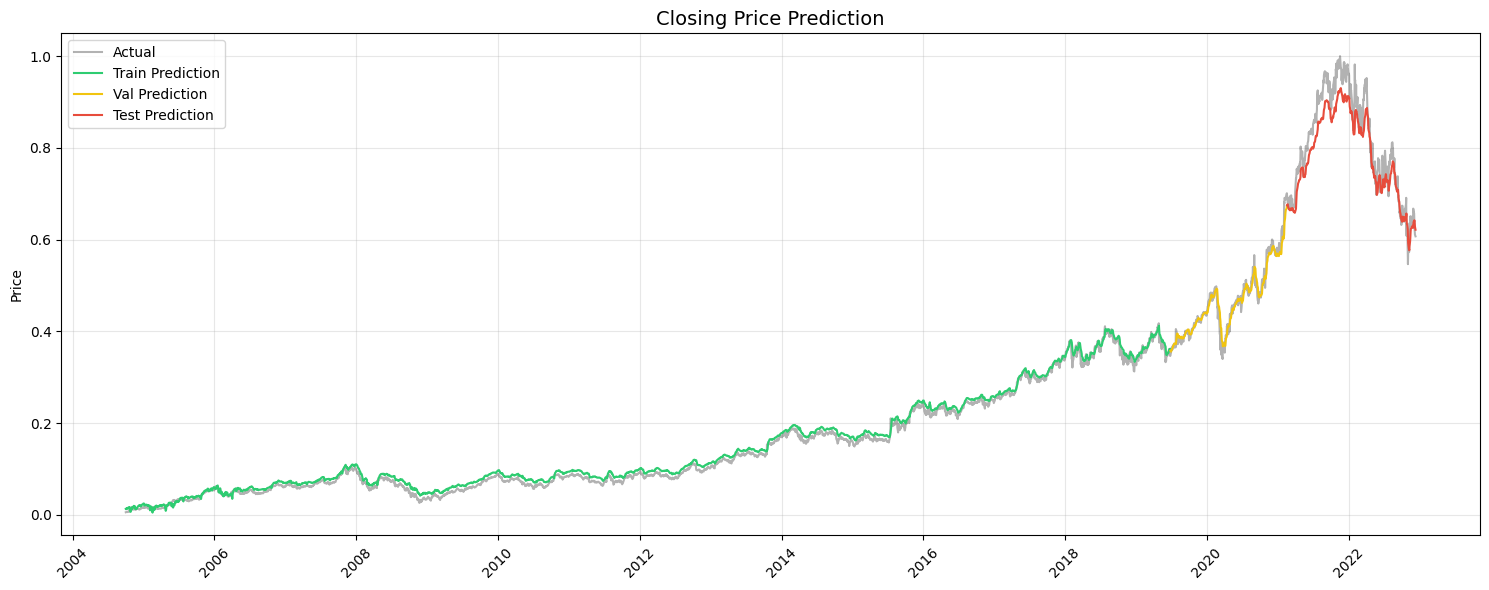


Train Set Metrics:

Val Set Metrics:

Test Set Metrics:


In [ ]:
train_pred, train_actual = make_predictions(lstm, train_loader, device)
val_pred, val_actual = make_predictions(lstm, val_loader, device)
test_pred, test_actual = make_predictions(lstm, test_loader, device)

all_predictions = np.concatenate([train_pred, val_pred, test_pred], axis=0)
all_actuals = np.concatenate([train_actual, val_actual, test_actual], axis=0)

valid_dates = dates[sequence_length:sequence_length+len(all_predictions)]

set_splits = {
    'train': (0, len(train_pred)),
    'val': (len(train_pred), len(train_pred) + len(val_pred)),
    'test': (len(train_pred) + len(val_pred), len(train_pred) + len(val_pred) + len(test_pred))
}

plot_predictions(
    all_predictions, 
    all_actuals, 
    valid_dates, 
    scalers, 
    set_splits, 
    title='Google Stock Price Prediction'
)

    

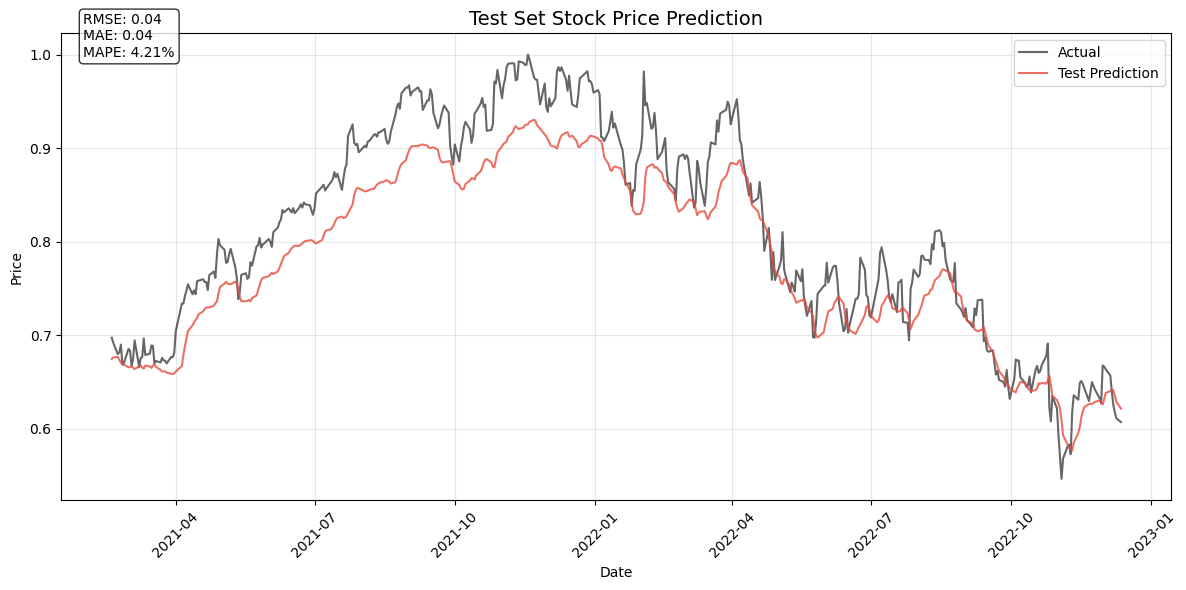


Test Set Metrics:
RMSE: 0.04
MAE: 0.04
MAPE: 4.21%


In [46]:
plot_test_predictions_only(gru, test_loader, dates, sequence_length, device)

## ATT-LSTM

In [ ]:
sequence_length = 30
prediction_length = 1
batch_size = 64
hidden_size = 128
num_layers = 1
num_epochs = 30
learning_rate = 0.002
dropout_rate = 0.3
weight_decay = 1e-4

input_size = X.shape[2]  
output_size = 1
attlstm = ATTLSTM(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout_rate).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(attlstm.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_model(attlstm, train_loader, val_loader, criterion, optimizer, num_epochs, "ATTLSTM",device)

Epoch [1/30] - Train Loss: 0.0134, Val Loss: 0.0276
Epoch [2/30] - Train Loss: 0.0290, Val Loss: 0.0296
Epoch [3/30] - Train Loss: 0.0218, Val Loss: 0.0294
Epoch [4/30] - Train Loss: 0.0144, Val Loss: 0.0178
Epoch [5/30] - Train Loss: 0.0090, Val Loss: 0.0120
Epoch [6/30] - Train Loss: 0.0046, Val Loss: 0.0064
Epoch [7/30] - Train Loss: 0.0032, Val Loss: 0.0029
Epoch [8/30] - Train Loss: 0.0012, Val Loss: 0.0009
Epoch [9/30] - Train Loss: 0.0008, Val Loss: 0.0007
Epoch [10/30] - Train Loss: 0.0006, Val Loss: 0.0004
Epoch [11/30] - Train Loss: 0.0003, Val Loss: 0.0003
Epoch [12/30] - Train Loss: 0.0002, Val Loss: 0.0002
Epoch [13/30] - Train Loss: 0.0002, Val Loss: 0.0002
Epoch [14/30] - Train Loss: 0.0001, Val Loss: 0.0002
Epoch [15/30] - Train Loss: 0.0001, Val Loss: 0.0002
Epoch [16/30] - Train Loss: 0.0001, Val Loss: 0.0002
Epoch [17/30] - Train Loss: 0.0001, Val Loss: 0.0002
Epoch [18/30] - Train Loss: 0.0001, Val Loss: 0.0001
Epoch [19/30] - Train Loss: 0.0001, Val Loss: 0.0002
Ep

In [112]:
attlstm = torch.load("ATTLSTM_best_model.pth", map_location=device) 
predictions, actuals, metrics = evaluate_metrics(attlstm, test_loader, criterion, scalers, device)



Evaluation Metrics:
MSE (normalized): 0.0003
MAE (normalized): 0.0142
MSE (original scale): 7.2294
MAE (original scale): 2.0948

Value Ranges:
Predictions - Min: 87.94, Max: 149.63
Actuals - Min: 83.49, Max: 150.71


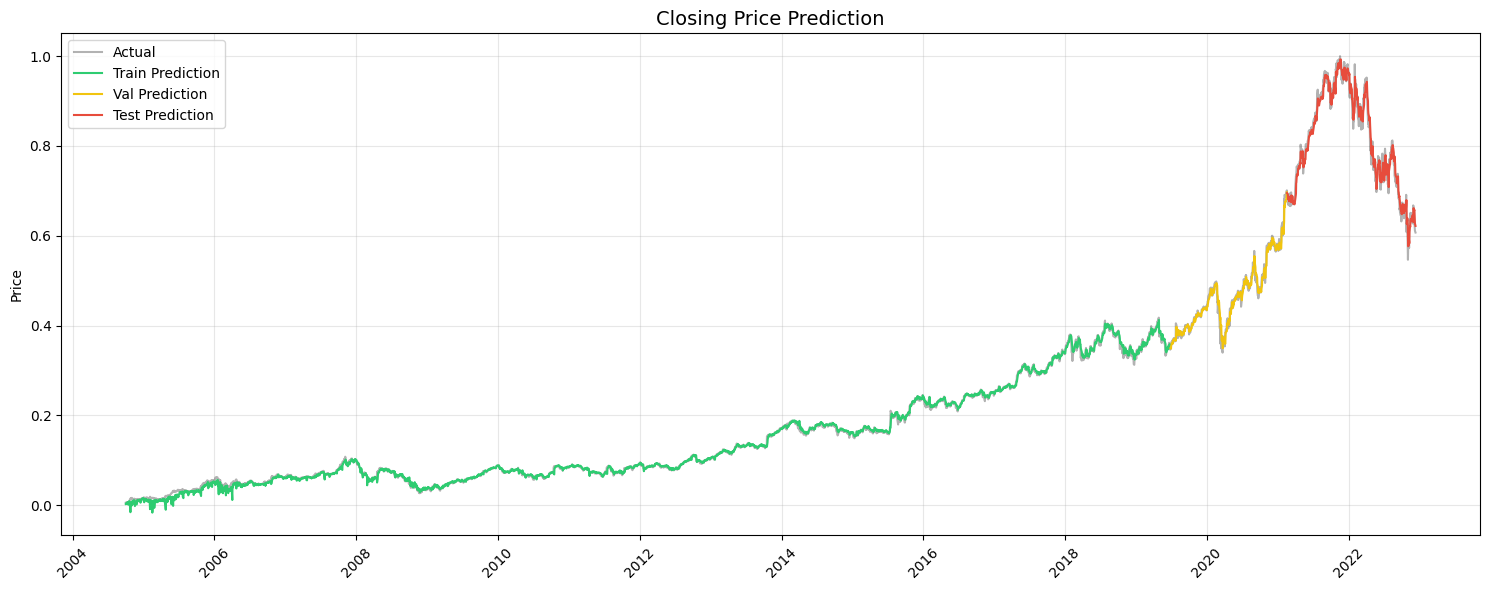

In [113]:
df = pd.read_csv(file_path)
dates = pd.to_datetime(df['Date'], format='%d-%m-%Y')

train_pred, train_actual = make_predictions(attlstm, train_loader, device)
val_pred, val_actual = make_predictions(attlstm, val_loader, device)
test_pred, test_actual = make_predictions(attlstm, test_loader, device)

all_predictions = np.concatenate([train_pred, val_pred, test_pred], axis=0)
all_actuals = np.concatenate([train_actual, val_actual, test_actual], axis=0)

valid_dates = dates[sequence_length:sequence_length+len(all_predictions)]

set_splits = {
    'train': (0, len(train_pred)),
    'val': (len(train_pred), len(train_pred) + len(val_pred)),
    'test': (len(train_pred) + len(val_pred), len(train_pred) + len(val_pred) + len(test_pred))
}

plot_predictions(
    all_predictions, 
    all_actuals, 
    valid_dates, 
    scalers, 
    set_splits, 
    title='Google Stock Price Prediction'
)

    

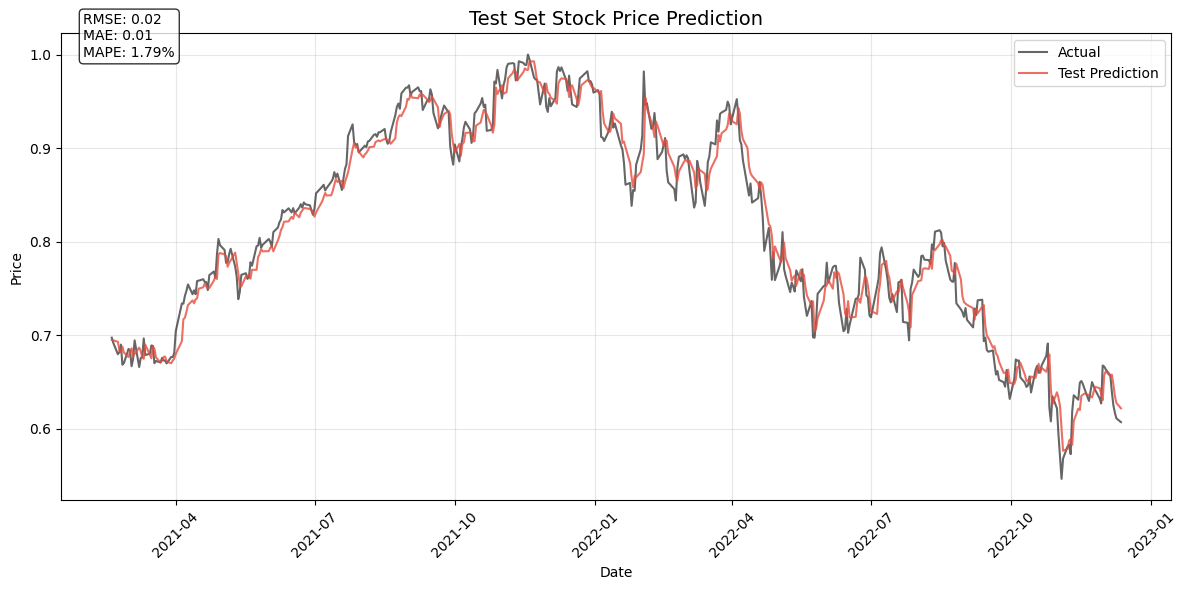


Test Set Metrics:
RMSE: 0.02
MAE: 0.01
MAPE: 1.79%


In [114]:
plot_test_predictions_only(attlstm, test_loader, dates, sequence_length, device)

In [117]:
sequence_length = 30
prediction_length = 1
batch_size = 64
hidden_size = 128
num_layers = 1
num_epochs = 30
learning_rate = 0.001
dropout_rate = 0.3
weight_decay = 1e-4

input_size = X.shape[2]  
output_size = 1
timeAttentionRNN = TimeAttentionRNN(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout_rate).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(timeAttentionRNN.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_model(timeAttentionRNN, train_loader, val_loader, criterion, optimizer, num_epochs,"TimeAttentionRNN", device)


Epoch [1/30] - Train Loss: 0.0114, Val Loss: 0.0290
Epoch [2/30] - Train Loss: 0.0085, Val Loss: 0.0112
Epoch [3/30] - Train Loss: 0.0065, Val Loss: 0.0049
Epoch [4/30] - Train Loss: 0.0038, Val Loss: 0.0024
Epoch [5/30] - Train Loss: 0.0024, Val Loss: 0.0004
Epoch [6/30] - Train Loss: 0.0017, Val Loss: 0.0003
Epoch [7/30] - Train Loss: 0.0014, Val Loss: 0.0003
Epoch [8/30] - Train Loss: 0.0013, Val Loss: 0.0006
Epoch [9/30] - Train Loss: 0.0012, Val Loss: 0.0004
Epoch [10/30] - Train Loss: 0.0011, Val Loss: 0.0004
Epoch [11/30] - Train Loss: 0.0010, Val Loss: 0.0003
Epoch [12/30] - Train Loss: 0.0010, Val Loss: 0.0002
Epoch [13/30] - Train Loss: 0.0008, Val Loss: 0.0002
Epoch [14/30] - Train Loss: 0.0006, Val Loss: 0.0002
Epoch [15/30] - Train Loss: 0.0007, Val Loss: 0.0002
Epoch [16/30] - Train Loss: 0.0005, Val Loss: 0.0002
Epoch [17/30] - Train Loss: 0.0005, Val Loss: 0.0001
Epoch [18/30] - Train Loss: 0.0005, Val Loss: 0.0001
Epoch [19/30] - Train Loss: 0.0004, Val Loss: 0.0001
Ep

In [119]:
timeAttentionRNN = torch.load("TimeAttentionRNN_best_model.pth", map_location=device) 
predictions, actuals, metrics = evaluate_metrics(timeAttentionRNN, test_loader, criterion, scalers, device)



Evaluation Metrics:
MSE (normalized): 0.0004
MAE (normalized): 0.0158
MSE (original scale): 8.6954
MAE (original scale): 2.2902

Value Ranges:
Predictions - Min: 85.95, Max: 152.88
Actuals - Min: 83.49, Max: 150.71


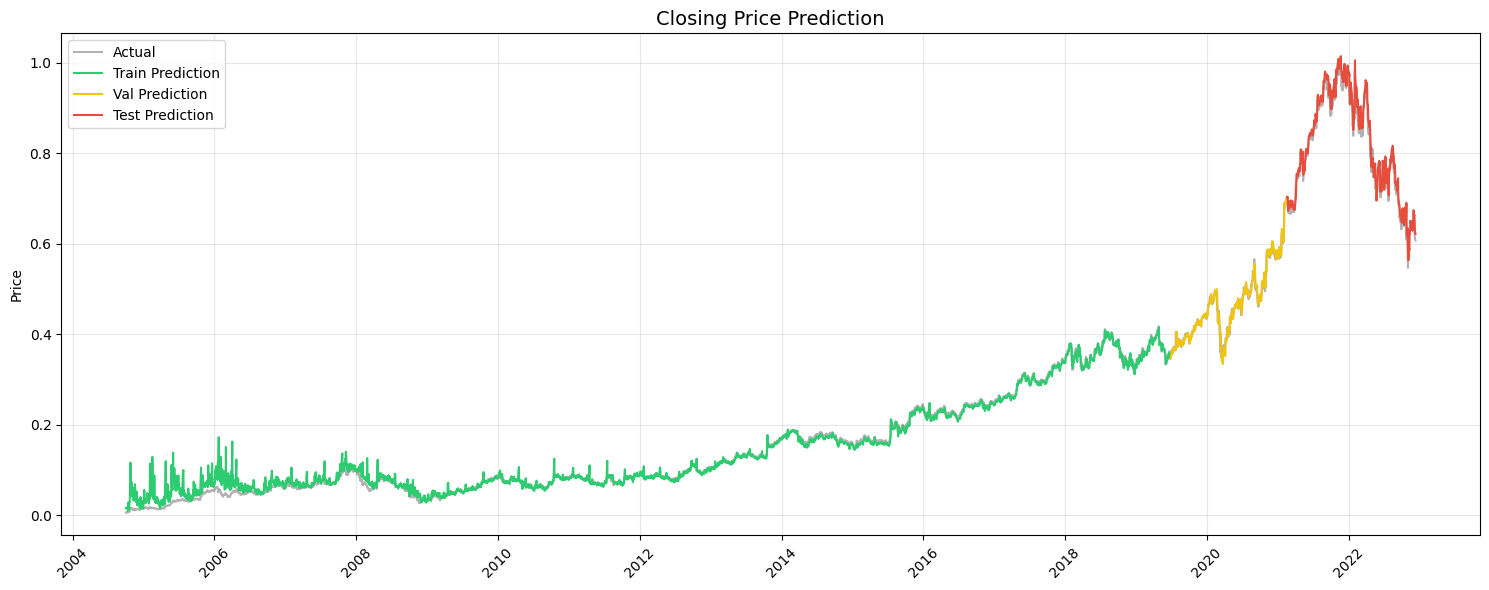

In [120]:
df = pd.read_csv(file_path)
dates = pd.to_datetime(df['Date'], format='%d-%m-%Y')

train_pred, train_actual = make_predictions(timeAttentionRNN, train_loader, device)
val_pred, val_actual = make_predictions(timeAttentionRNN, val_loader, device)
test_pred, test_actual = make_predictions(timeAttentionRNN, test_loader, device)

all_predictions = np.concatenate([train_pred, val_pred, test_pred], axis=0)
all_actuals = np.concatenate([train_actual, val_actual, test_actual], axis=0)

valid_dates = dates[sequence_length:sequence_length+len(all_predictions)]

set_splits = {
    'train': (0, len(train_pred)),
    'val': (len(train_pred), len(train_pred) + len(val_pred)),
    'test': (len(train_pred) + len(val_pred), len(train_pred) + len(val_pred) + len(test_pred))
}

plot_predictions(
    all_predictions, 
    all_actuals, 
    valid_dates, 
    scalers, 
    set_splits, 
    title='Google Stock Price Prediction'
)

    

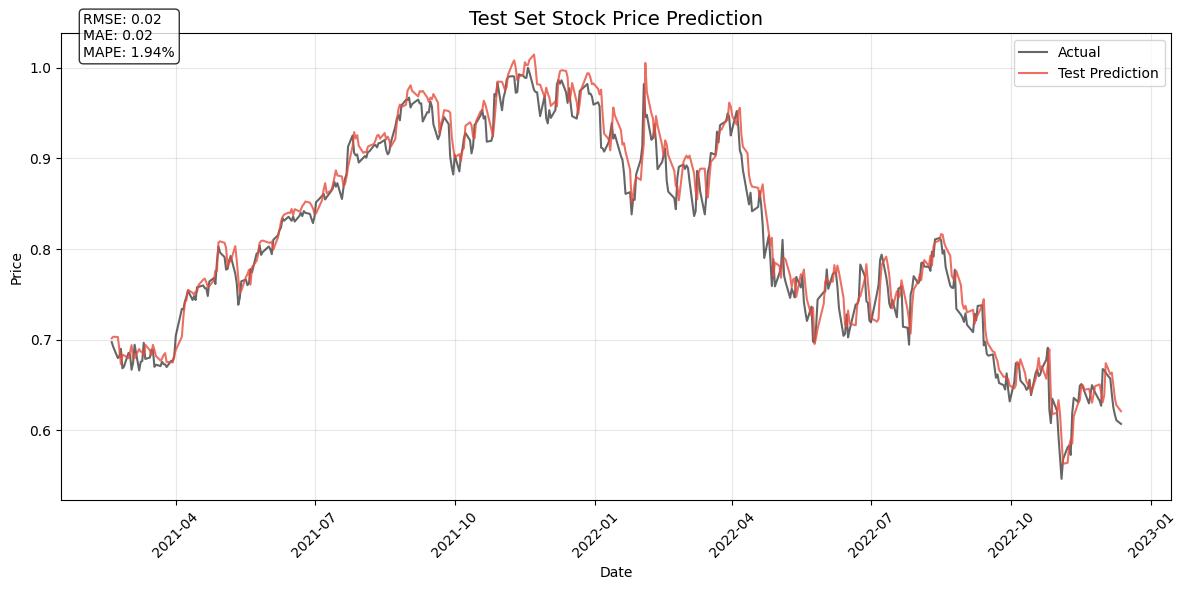


Test Set Metrics:
RMSE: 0.02
MAE: 0.02
MAPE: 1.94%


In [121]:
plot_test_predictions_only(timeAttentionRNN, test_loader, dates, sequence_length, device)

FeatureAttentionRNN

In [123]:
sequence_length = 30
prediction_length = 1
batch_size = 64
hidden_size = 128
num_layers = 1
num_epochs = 30
learning_rate = 0.0005
dropout_rate = 0.3
weight_decay = 1e-4

input_size = X.shape[2]  
output_size = 1
featureAttentionRNN = FeatureAttentionRNN(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout_rate).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(featureAttentionRNN.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_model(featureAttentionRNN, train_loader, val_loader, criterion, optimizer, num_epochs,"FeatureAttentionRNN",device)


Epoch [1/30] - Train Loss: 0.0052, Val Loss: 0.0295
Epoch [2/30] - Train Loss: 0.0049, Val Loss: 0.0110
Epoch [3/30] - Train Loss: 0.0042, Val Loss: 0.0105
Epoch [4/30] - Train Loss: 0.0031, Val Loss: 0.0104
Epoch [5/30] - Train Loss: 0.0022, Val Loss: 0.0059
Epoch [6/30] - Train Loss: 0.0015, Val Loss: 0.0057
Epoch [7/30] - Train Loss: 0.0011, Val Loss: 0.0038
Epoch [8/30] - Train Loss: 0.0008, Val Loss: 0.0026
Epoch [9/30] - Train Loss: 0.0006, Val Loss: 0.0018
Epoch [10/30] - Train Loss: 0.0005, Val Loss: 0.0013
Epoch [11/30] - Train Loss: 0.0005, Val Loss: 0.0009
Epoch [12/30] - Train Loss: 0.0004, Val Loss: 0.0009
Epoch [13/30] - Train Loss: 0.0004, Val Loss: 0.0007
Epoch [14/30] - Train Loss: 0.0003, Val Loss: 0.0005
Epoch [15/30] - Train Loss: 0.0003, Val Loss: 0.0004
Epoch [16/30] - Train Loss: 0.0003, Val Loss: 0.0004
Epoch [17/30] - Train Loss: 0.0003, Val Loss: 0.0004
Epoch [18/30] - Train Loss: 0.0003, Val Loss: 0.0003
Epoch [19/30] - Train Loss: 0.0003, Val Loss: 0.0003
Ep

In [125]:
featureAttentionRNN = torch.load("FeatureAttentionRNN_best_model.pth", map_location=device) 
predictions, actuals, metrics = evaluate_metrics(featureAttentionRNN, test_loader, criterion, scalers, device)



Evaluation Metrics:
MSE (normalized): 0.0004
MAE (normalized): 0.0166
MSE (original scale): 9.2434
MAE (original scale): 2.4629

Value Ranges:
Predictions - Min: 88.23, Max: 148.90
Actuals - Min: 83.49, Max: 150.71


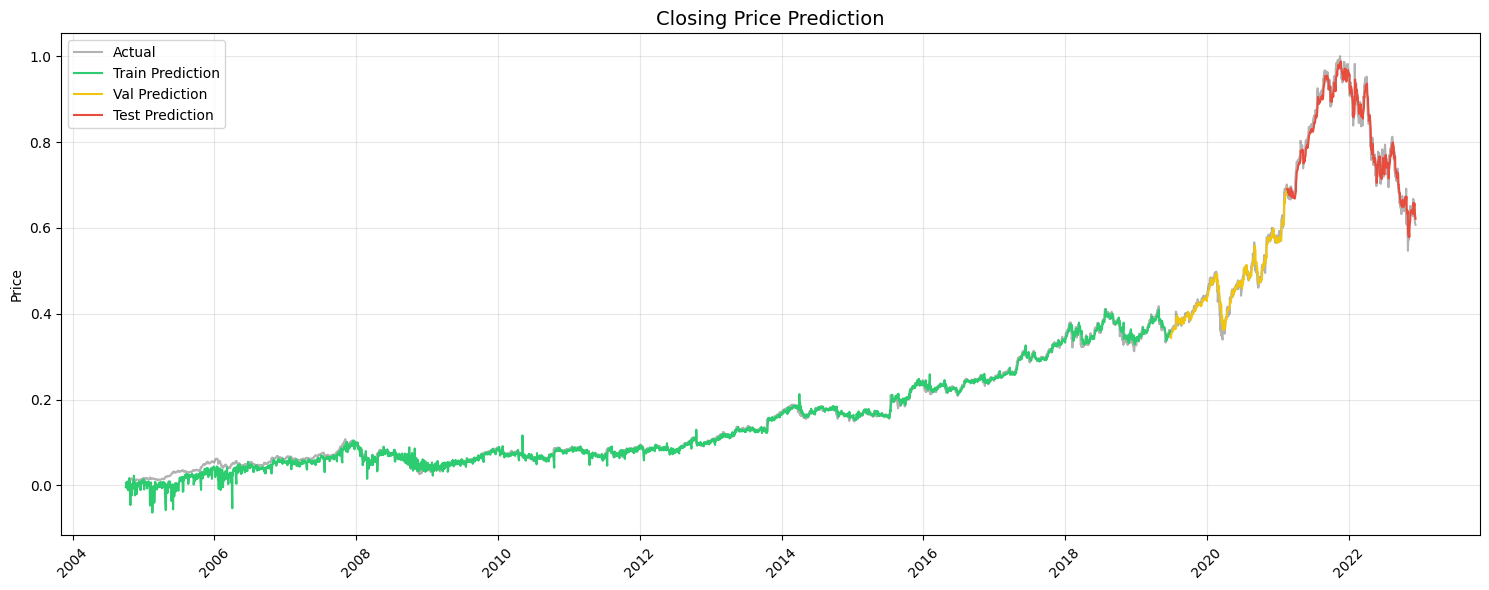

In [ ]:
train_pred, train_actual = make_predictions(featureAttentionRNN, train_loader, device)
val_pred, val_actual = make_predictions(featureAttentionRNN, val_loader, device)
test_pred, test_actual = make_predictions(featureAttentionRNN, test_loader, device)

all_predictions = np.concatenate([train_pred, val_pred, test_pred], axis=0)
all_actuals = np.concatenate([train_actual, val_actual, test_actual], axis=0)

valid_dates = dates[sequence_length:sequence_length+len(all_predictions)]

set_splits = {
    'train': (0, len(train_pred)),
    'val': (len(train_pred), len(train_pred) + len(val_pred)),
    'test': (len(train_pred) + len(val_pred), len(train_pred) + len(val_pred) + len(test_pred))
}

plot_predictions(
    all_predictions, 
    all_actuals, 
    valid_dates, 
    scalers, 
    set_splits, 
    title='Google Stock Price Prediction'
)

    

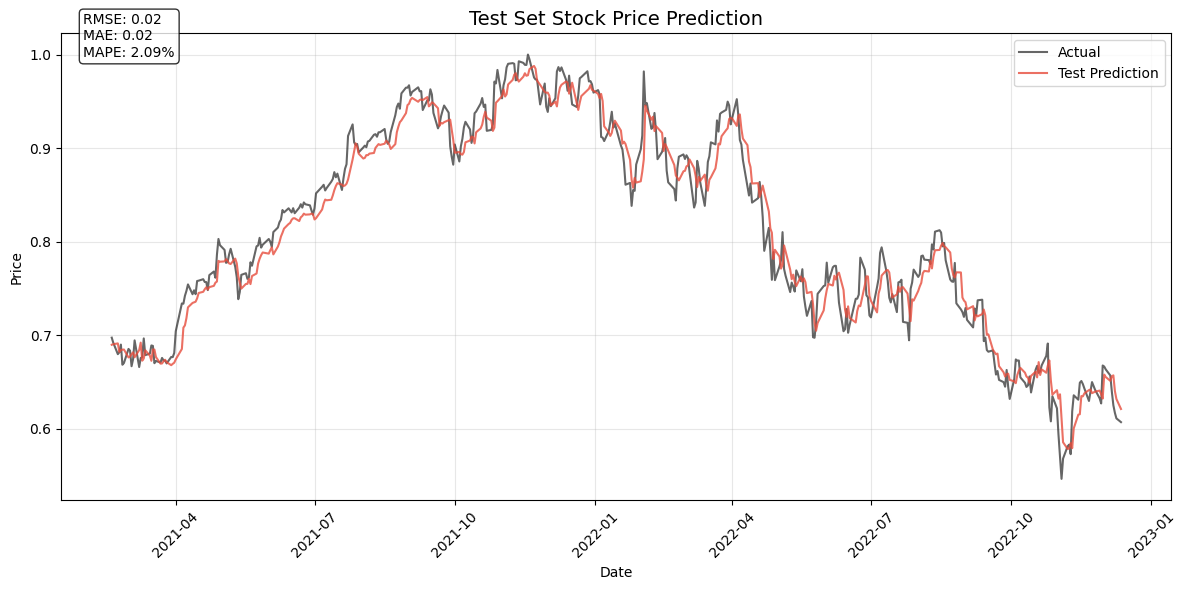


Test Set Metrics:
RMSE: 0.02
MAE: 0.02
MAPE: 2.09%


In [127]:
plot_test_predictions_only(featureAttentionRNN, test_loader, dates, sequence_length, device)

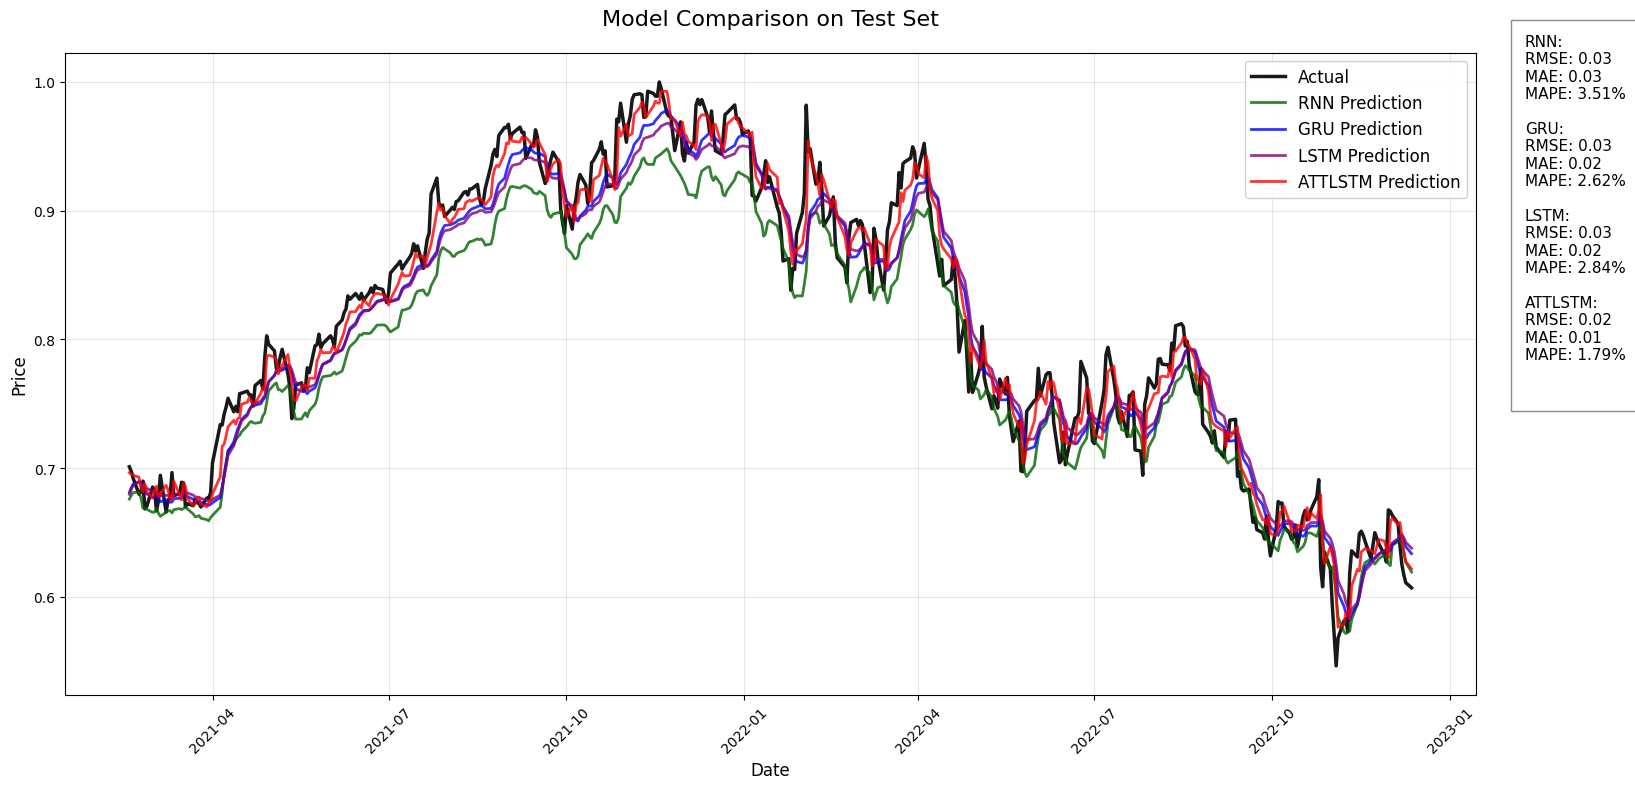

In [ ]:
import matplotlib.pyplot as plt
def plot_multiple_models_comparison(models_dict, test_loader, dates, sequence_length, device, figsize=(15, 8)):
    plt.figure(figsize=figsize)
    
    
    colors = {
        'RNN': '#006400',      
        'GRU': '#0000FF',     
        'LSTM': '#800080',   
        'ATTLSTM': '#FF0000'   
    }
    
    predictions_dict = {}
    test_actual = None
    
    for model_name, model in models_dict.items():
        pred, actual = make_predictions(model, test_loader, device)
        predictions_dict[model_name] = pred
        if test_actual is None:
            test_actual = actual
    
    test_dates = dates[-(len(test_actual)+sequence_length):]
    test_dates = test_dates[sequence_length:]
    
    plt.plot(test_dates, test_actual, 'k-', label='Actual', linewidth=2.5, alpha=0.9)
    
    for model_name, predictions in predictions_dict.items():
        plt.plot(test_dates, predictions, color=colors[model_name], 
                label=f'{model_name} Prediction', alpha=0.8, 
                linewidth=2)
    
    plt.title('Model Comparison on Test Set', fontsize=16, pad=20)
    plt.legend(loc='best', fontsize=12, framealpha=0.9)
    plt.grid(True, alpha=0.3)
    plt.ylabel('Price', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.xticks(rotation=45)
    
    metrics_text = ""
    for model_name, predictions in predictions_dict.items():
        rmse = np.sqrt(np.mean((predictions - test_actual) ** 2))
        mae = np.mean(np.abs(predictions - test_actual))
        mape = np.mean(np.abs((test_actual - predictions) / test_actual)) * 100
        metrics_text += f'{model_name}:\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nMAPE: {mape:.2f}%\n\n'
    
    plt.figtext(1.02, 0.5, metrics_text, fontsize=11, 
               bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', pad=10))
    
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_model = torch.load("rnn_best_model.pth", map_location=device)
gru_model = torch.load("GRU_best_model.pth", map_location=device)
lstm_model = torch.load("LSTM_best_model.pth", map_location=device)
attlstm_model = torch.load("ATTLSTM_best_model.pth", map_location=device)

models = {
    'RNN': rnn_model,
    'GRU': gru_model,
    'LSTM': lstm_model,
    'ATTLSTM': attlstm_model
}

df = pd.read_csv("GOOG.csv")
dates = pd.to_datetime(df['Date'], format='%d-%m-%Y')

plot_multiple_models_comparison(models, test_loader, dates, sequence_length, device)